In [3]:
# Install libraries
!pip install sagemaker
!pip install pandas_ta
!pip install tensorflow
!pip install keras
!pip install matplotlib
!pip install sklearn
!pip install boto3
!pip install datetime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.4/388.4 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.

In [4]:
# Import libraries
from sagemaker import get_execution_role
import boto3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [6]:
# Transform data before training
stock_data = pd.read_csv("/content/nvidia_indexes.csv")
sentiment_data = pd.read_csv("/content/sentiment_news.csv")
print(stock_data.head())
print("")
print(sentiment_data.head())

         Date      Open      High       Low     Close  Adj_Close      Volume
0  1999-01-22  0.043750  0.048828  0.038802  0.041016   0.037618 -1580279296
1  1999-01-25  0.044271  0.045833  0.041016  0.045313   0.041559   510480000
2  1999-01-26  0.045833  0.046745  0.041146  0.041797   0.038334   343200000
3  1999-01-27  0.041927  0.042969  0.039583  0.041667   0.038215   244368000
4  1999-01-28  0.041667  0.041927  0.041276  0.041536   0.038095   227520000

         Date                                            Content  Positive  \
0  11-23-2016  NVIDIA Foundation Awards $400,000 to Two Trail...     0.137   
1  11-22-2016  NVIDIA’s Lens Matched Shading Technology Takes...     0.068   
2  11-21-2016  NASA Program Deploys Deep Learning to Ward Off...     0.077   
3  11-19-2016  City of Angels: NVIDIA-Powered Cars Unveiled a...     0.174   
4  11-18-2016  Sleepless in Salt Lake: Tesla P100 Powers Winn...     0.199   

   Negative  Neutral  
0     0.238    0.625  
1     0.000    0.932  

## Part 1: Train LSTM Prediction model without effection of Sentiment News:

In [57]:
# Data cleaning
data = stock_data.copy()
# Filter data from 01-01-2017 to 02-10-2024
data = data[(data['Date'] >= '2017-01-01') & (data['Date'] <= '2024-10-02')]
# Adding indicators
data['SMA200']=ta.sma(data.Close, length=200)
data['SMA50']=ta.sma(data.Close, length=50)
data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=100)
data['EMAS']=ta.ema(data.Close, length=150)
data['Target'] = data['Adj_Close']-data['Open']
data['Target'] = data['Target'].shift(-1)
data['TargetClass'] = [1 if data.Target.iloc[i]>0 else 0 for i in range(len(data))]
data['TargetNextClose'] = data['Adj_Close'].shift(-1)
data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['index', 'Close'], axis=1, inplace=True)

In [58]:
# Get data det for train
data_set = data.drop(['Date','Target','TargetClass'], axis=1)
pd.set_option('display.max_columns', None)
print("Shape of trained_dataset:", data_set.shape)
print("Shape of original dataset:", data.shape)

Shape of trained_dataset: (1750, 12)
Shape of original dataset: (1750, 15)


In [59]:
# First 10 rows of trained_dataset
data_set.head(10)

,Open,High,Low,Adj_Close,Volume,SMA200,SMA50,RSI,EMAF,EMAM,EMAS,TargetNextClose
0,4.92725,4.97250,4.90875,4.887254,478596000,3.415799,4.350175,75.169046,4.626569,4.074459,3.731693,4.883054
1,4.95275,4.95350,4.83300,4.883054,567316000,3.427745,4.363815,74.768477,4.656372,4.091588,3.747691,4.888489
2,4.86100,4.95000,4.81125,4.888489,570772000,3.439421,4.376660,74.953549,4.683860,4.108487,3.763549,4.866246
3,4.96225,4.98975,4.91350,4.866246,451620000,3.451316,4.392740,72.618981,4.706588,4.124606,3.778900,4.859327
4,4.94450,4.97125,4.89500,4.859327,428696000,3.463006,4.413070,71.872781,4.726484,4.140268,3.793954,4.910239
5,4.92475,4.96875,4.89850,4.910239,407244000,3.474431,4.428210,73.980339,4.749390,4.156639,3.809491,4.786174
6,4.92700,4.98050,4.77925,4.786174,828160000,3.485330,4.441550,61.875169,4.758163,4.170200,3.823160,4.836344
7,4.86950,4.90400,4.84525,4.836344,322744000,3.496646,4.456820,64.399074,4.770933,4.184498,3.837320,4.988832
8,4.94500,5.04675,4.91875,4.988832,572192000,3.508949,4.477015,70.712891,4.797177,4.201568,3.853336,5.037764
9,5.04650,5.15225,5.03050,5.037764,504056000,3.521500,4.498185,72.396122,4.825637,4.219279,3.869795,5.111167


In [60]:
# Data normalization with MinMaxScaler. It's possible to use another kind of scaler such as Simple or Standard
from sklearn.preprocessing import MinMaxScaler, StandardScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)
print("")
print("Shape of scaled data set after normalize:", data_set_scaled.shape)

[[1.29173660e-02 1.25299514e-02 1.38989321e-02 ... 0.00000000e+00
  0.00000000e+00 1.30754419e-02]
 [1.31039930e-02 1.23917797e-02 1.33131247e-02 ... 1.59198755e-04
  1.58898377e-04 1.31164901e-02]
 [1.24325085e-02 1.23663272e-02 1.31449225e-02 ... 3.16257315e-04
  3.16415759e-04 1.29485127e-02]
 ...
 [8.84146208e-01 8.78336590e-01 8.98227911e-01 ... 9.97145781e-01
  9.96028063e-01 8.93303515e-01]
 [8.42722783e-01 8.59938003e-01 8.89643783e-01 ... 9.98999807e-01
  9.98321280e-01 8.59772998e-01]
 [8.68045207e-01 8.66773862e-01 8.71392851e-01 ... 1.00000000e+00
  1.00000000e+00 8.73744028e-01]]

Shape of scaled data set after normalize: (1750, 12)


In [61]:
# Multiple feature from data provided to the model
X = []
backcandles = 7
for j in range(11):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])

X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(data_set_scaled[backcandles:,-1])
y = np.reshape(yi,(len(yi),1))

print("Number of example:",data_set_scaled.shape[0],'\n')
print(X)
print("Shape of X:",X.shape,'\n')
print(y)
print("Shape of Y:",y.shape)

Number of example: 1750 

[[[1.29173660e-02 1.25299514e-02 1.38989321e-02 ... 8.90772237e-03
   0.00000000e+00 0.00000000e+00]
  [1.31039930e-02 1.23917797e-02 1.33131247e-02 ... 9.15104456e-03
   1.59198755e-04 1.58898377e-04]
  [1.24325085e-02 1.23663272e-02 1.31449225e-02 ... 9.37547002e-03
   3.16257315e-04 3.16415759e-04]
  ...
  [1.30436127e-02 1.25208627e-02 1.37925966e-02 ... 9.72346814e-03
   6.11617926e-04 6.18417295e-04]
  [1.28990690e-02 1.25026819e-02 1.38196636e-02 ... 9.91048321e-03
   7.63766453e-04 7.72742620e-04]
  [1.29155374e-02 1.25881315e-02 1.28974518e-02 ... 9.98210365e-03
   8.89805580e-04 9.08513162e-04]]

 [[1.31039930e-02 1.23917797e-02 1.33131247e-02 ... 9.15104456e-03
   1.59198755e-04 1.58898377e-04]
  [1.24325085e-02 1.23663272e-02 1.31449225e-02 ... 9.37547002e-03
   3.16257315e-04 3.16415759e-04]
  [1.31735201e-02 1.26553968e-02 1.39356642e-02 ... 9.56102654e-03
   4.66064988e-04 4.68886725e-04]
  ...
  [1.28990690e-02 1.25026819e-02 1.38196636e-02 ...

In [62]:
# Split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_train:", y_test.shape)

1394
Shape of X_train: (1394, 7, 11)
Shape of X_test: (349, 7, 11)
Shape of y_train: (1394, 1)
Shape of y_train: (349, 1)


### Model Training

In [63]:
!pip install tensorflow
!pip install keras

In [64]:
# Start Model Training
# Import Libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
tf.random.set_seed(20)
np.random.seed(10)

In [65]:
# Training phase:
lstm_input = Input(shape=(backcandles, 11), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = BatchNormalization()(inputs)  # Add Batch Normalization
inputs = Dropout(0.2)(inputs)  # Add Dropout layer with 10% dropout
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')


history = model.fit(x=X_train, y=y_train, batch_size=4, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0487 - val_loss: 0.0185
Epoch 2/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0094 - val_loss: 1.7691e-04
Epoch 3/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0045 - val_loss: 3.1775e-04
Epoch 4/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0026 - val_loss: 0.0142
Epoch 5/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 6/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0012 - val_loss: 0.0057
Epoch 7/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9.7295e-04 - val_loss: 0.0040
Epoch 8/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9.4055e-04 - val_loss: 0.0012
Epoch 9/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 8.8854e-04 - val_loss: 8.7460e-05
Epoch 10/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 8.9734e-04 - val_loss: 0.0051
Epoch 11/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 8.6773e-04 - val_loss: 0.0081
Epoch 12/30
314/

In [66]:
# Test phase:
# Predict on training and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the model using appropriate metrics
# For regression tasks, you can use metrics like Mean Squared Error (MSE) or R-squared
from sklearn.metrics import mean_squared_error, r2_score

# Calculate MSE and R-squared for training data
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate MSE and R-squared for test data
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation results
print(f"Training MSE: {train_mse}")
print(f"Training R-squared: {train_r2}")
print(f"Test MSE: {test_mse}")
print(f"Test R-squared: {test_r2}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training MSE: 0.0006273203103251115
Training R-squared: 0.8148549843973479
Test MSE: 0.008290224733769896
Test R-squared: 0.8577741526294038


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


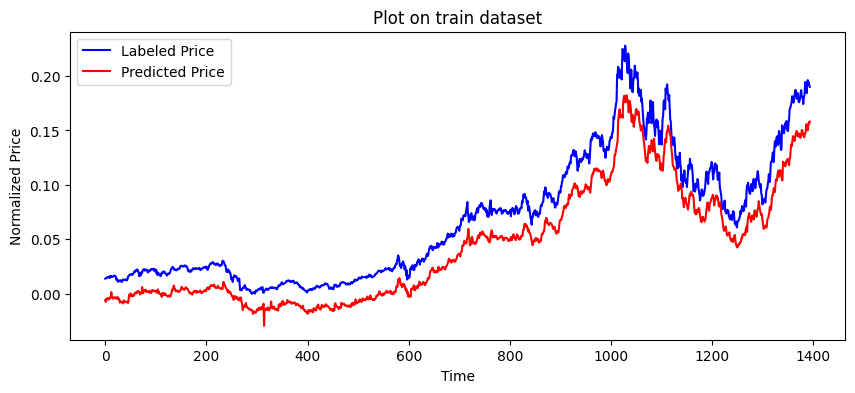

In [67]:
# Demo on test set
y_pred = model.predict(X_train)
plt.figure(figsize=(10,4))
plt.plot(y_train, color = 'blue', label = 'Labeled Price')
plt.plot(y_pred, color = 'red', label = 'Predicted Price')
# label x tick with datetime
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.title('Plot on train dataset')
plt.legend()
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


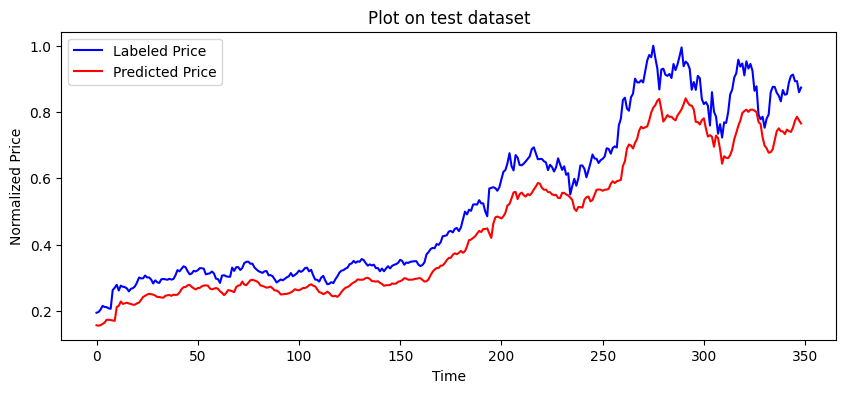

In [68]:
y_pred = model.predict(X_test)
plt.figure(figsize=(10,4))
plt.plot(y_test, color = 'blue', label = 'Labeled Price')
plt.plot(y_pred, color = 'red', label = 'Predicted Price')
# label x tick with datetime
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.title('Plot on test dataset')
plt.legend()
plt.show()

## Model Training with sentiment news

In [70]:
# Preparing data for model
sentiment_news = sentiment_data.copy()
sentiment_news = sentiment_news.drop(['Content'], axis=1)
sentiment_news.head()

# Group by 'Date' and calculate the mean for each column
sentiment_news['Date'] = pd.to_datetime(sentiment_news['Date'], errors='coerce')
sentiment_news['Date'] = sentiment_news['Date'].dt.strftime('%m-%d-%Y')
grouped_df = sentiment_news.groupby('Date').mean().reset_index()

# Rename columns for clarity
grouped_df = grouped_df.rename(columns={
    'Positive': 'Pos_mean',
    'Negative': 'Neg_mean',
    'Neutral': 'Neu_mean'
})

In [71]:
grouped_df.head(20)

,Date,Pos_mean,Neg_mean,Neu_mean
0,01-01-2018,0.000000,0.083500,0.916500
1,01-02-2018,0.000000,0.000000,1.000000
2,01-02-2019,0.013000,0.000000,0.987000
3,01-02-2020,0.025000,0.000000,0.975000
4,01-02-2022,0.000000,0.000000,1.000000
5,01-02-2023,0.113000,0.037000,0.850000
6,01-02-2024,0.117222,0.039889,0.842778
7,01-03-2017,0.071000,0.016500,0.912500
8,01-03-2018,0.096333,0.000000,0.903667
9,01-03-2019,0.030286,0.106429,0.863429


In [72]:
# Shape of sentiments news:
print("Shape of sentiment news:", grouped_df.shape)

Shape of sentiment news: (2341, 4)


In [73]:
# Filter data from 01-01-2017 to 02-10-2024
sentiment = grouped_df.copy()
# Convert 'Date' column from object to datetime
sentiment['Date'] = pd.to_datetime(sentiment['Date'])
filtered_data = sentiment[(sentiment['Date'] >= '2017-01-01') & (sentiment['Date'] <= '2024-10-02')]

# Shape of filter group sentiments news:
print(filtered_data.head(10), '\n')
print("Shape of sentiment news:", filtered_data.shape)

        Date  Pos_mean  Neg_mean  Neu_mean
0 2018-01-01  0.000000  0.083500  0.916500
1 2018-01-02  0.000000  0.000000  1.000000
2 2019-01-02  0.013000  0.000000  0.987000
3 2020-01-02  0.025000  0.000000  0.975000
4 2022-01-02  0.000000  0.000000  1.000000
5 2023-01-02  0.113000  0.037000  0.850000
6 2024-01-02  0.117222  0.039889  0.842778
7 2017-01-03  0.071000  0.016500  0.912500
8 2018-01-03  0.096333  0.000000  0.903667
9 2019-01-03  0.030286  0.106429  0.863429 

Shape of sentiment news: (2285, 4)


In [76]:
# Merge stock data with sentiment data:
final_stock_data = data.copy()
final_sentiment_news = filtered_data.copy()
# Convert 'Date' column from object to datetime
final_stock_data['Date'] = pd.to_datetime(final_stock_data['Date'])

final_data_set = pd.merge(final_stock_data, final_sentiment_news, on='Date', how='left')

# Replace nan or null with 0
final_data_set.fillna(0, inplace=True)

# Remove date, target, target class
final_data_set = final_data_set.drop(['Date','Target','TargetClass'], axis=1)
# Rearrange order of columns
final_data_set = final_data_set[['Open','High','Low','Adj_Close','Volume','SMA200','SMA50','RSI','EMAF','EMAM','EMAS','Pos_mean','Neg_mean','Neu_mean','TargetNextClose']]

In [78]:
final_data_set.head(10)

,Open,High,Low,Adj_Close,Volume,SMA200,SMA50,RSI,EMAF,EMAM,EMAS,Pos_mean,Neg_mean,Neu_mean,TargetNextClose
0,4.92725,4.97250,4.90875,4.887254,478596000,3.415799,4.350175,75.169046,4.626569,4.074459,3.731693,0.061727,0.042091,0.896182,4.883054
1,4.95275,4.95350,4.83300,4.883054,567316000,3.427745,4.363815,74.768477,4.656372,4.091588,3.747691,0.186286,0.000000,0.813714,4.888489
2,4.86100,4.95000,4.81125,4.888489,570772000,3.439421,4.376660,74.953549,4.683860,4.108487,3.763549,0.000000,0.000000,1.000000,4.866246
3,4.96225,4.98975,4.91350,4.866246,451620000,3.451316,4.392740,72.618981,4.706588,4.124606,3.778900,0.083500,0.000000,0.916500,4.859327
4,4.94450,4.97125,4.89500,4.859327,428696000,3.463006,4.413070,71.872781,4.726484,4.140268,3.793954,0.184667,0.000000,0.815333,4.910239
5,4.92475,4.96875,4.89850,4.910239,407244000,3.474431,4.428210,73.980339,4.749390,4.156639,3.809491,0.123000,0.066600,0.810400,4.786174
6,4.92700,4.98050,4.77925,4.786174,828160000,3.485330,4.441550,61.875169,4.758163,4.170200,3.823160,0.055250,0.000000,0.944750,4.836344
7,4.86950,4.90400,4.84525,4.836344,322744000,3.496646,4.456820,64.399074,4.770933,4.184498,3.837320,0.068500,0.000000,0.931500,4.988832
8,4.94500,5.04675,4.91875,4.988832,572192000,3.508949,4.477015,70.712891,4.797177,4.201568,3.853336,0.084500,0.006250,0.909250,5.037764
9,5.04650,5.15225,5.03050,5.037764,504056000,3.521500,4.498185,72.396122,4.825637,4.219279,3.869795,0.180000,0.118250,0.702000,5.111167


In [79]:
print("Shape of final sentiment news dataset:",final_data_set.shape)

Shape of final sentiment news dataset: (1750, 15)


In [80]:
final_data_set_scaled = sc.fit_transform(final_data_set)
print(final_data_set_scaled)
print("")
print("Shape of scaled data set after normalize:", final_data_set_scaled.shape)

[[0.01291737 0.01252995 0.01389893 ... 0.14219902 0.89618182 0.01307544]
 [0.01310399 0.01239178 0.01331312 ... 0.         0.81371429 0.01311649]
 [0.01243251 0.01236633 0.01314492 ... 0.         1.         0.01294851]
 ...
 [0.88414621 0.87833659 0.89822791 ... 0.0722973  0.821      0.89330352]
 [0.84272278 0.859938   0.88964378 ... 0.03217503 0.9237619  0.859773  ]
 [0.86804521 0.86677386 0.87139285 ... 0.25168919 0.87533333 0.87374403]]

Shape of scaled data set after normalize: (1750, 15)


In [81]:
# Multiple feature from data provided to the model
X = []
backcandles = 7
for j in range(15):
    X.append([])
    for i in range(backcandles, final_data_set_scaled.shape[0]):
        X[j].append(final_data_set_scaled[i-backcandles:i, j])

X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(final_data_set_scaled[backcandles:,-1])
y = np.reshape(yi,(len(yi),1))

print("Number of example:",final_data_set_scaled.shape[0],'\n')
print(X)
print("Shape of X:",X.shape,'\n')
print(y)
print("Shape of Y:",y.shape)

Number of example: 1750 

[[[0.01291737 0.01252995 0.01389893 ... 0.14219902 0.89618182 0.01307544]
  [0.01310399 0.01239178 0.01331312 ... 0.         0.81371429 0.01311649]
  [0.01243251 0.01236633 0.01314492 ... 0.         1.         0.01294851]
  ...
  [0.01304361 0.01252086 0.0137926  ... 0.         0.81533333 0.01328074]
  [0.01289907 0.01250268 0.01381966 ... 0.225      0.8104     0.01234381]
  [0.01291554 0.01258813 0.01289745 ... 0.         0.94475    0.01272269]]

 [[0.01310399 0.01239178 0.01331312 ... 0.         0.81371429 0.01311649]
  [0.01243251 0.01236633 0.01314492 ... 0.         1.         0.01294851]
  [0.01317352 0.0126554  0.01393566 ... 0.         0.9165     0.01289626]
  ...
  [0.01289907 0.01250268 0.01381966 ... 0.225      0.8104     0.01234381]
  [0.01291554 0.01258813 0.01289745 ... 0.         0.94475    0.01272269]
  [0.01249472 0.01203181 0.01340786 ... 0.         0.9315     0.01387427]]

 [[0.01243251 0.01236633 0.01314492 ... 0.         1.         0.012948

In [82]:
# Split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_train:", y_test.shape)

1394
Shape of X_train: (1394, 7, 15)
Shape of X_test: (349, 7, 15)
Shape of y_train: (1394, 1)
Shape of y_train: (349, 1)


In [84]:
# Training phase:
lstm_input = Input(shape=(backcandles, 15), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = BatchNormalization()(inputs)  # Add Batch Normalization
inputs = Dropout(0.2)(inputs)  # Add Dropout layer with 10% dropout
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')


history = model.fit(x=X_train, y=y_train, batch_size=4, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0975 - val_loss: 0.0035
Epoch 2/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0160 - val_loss: 0.0072
Epoch 3/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0068 - val_loss: 0.0082
Epoch 4/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0029 - val_loss: 0.0195
Epoch 5/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0017 - val_loss: 9.6851e-04
Epoch 6/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 7/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0010 - val_loss: 2.7883e-04
Epoch 8/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9.3776e-04 - val_loss: 2.8405e-04
Epoch 9/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9.1147e-04 - val_loss: 1.7461e-04
Epoch 10/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.9540e-04 - val_loss: 5.4122e-04
Epoch 11/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9.4006e-04 - val_loss: 2.5918e-04
Epoch 12/30


In [85]:
# Test phase:
# Predict on training and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the model using appropriate metrics
# For regression tasks, you can use metrics like Mean Squared Error (MSE) or R-squared
from sklearn.metrics import mean_squared_error, r2_score

# Calculate MSE and R-squared for training data
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate MSE and R-squared for test data
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation results
print(f"Training MSE: {train_mse}")
print(f"Training R-squared: {train_r2}")
print(f"Test MSE: {test_mse}")
print(f"Test R-squared: {test_r2}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training MSE: 8.407183086956543e-05
Training R-squared: 0.9751873481825858
Test MSE: 0.004010782172808141
Test R-squared: 0.9311916248997609


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


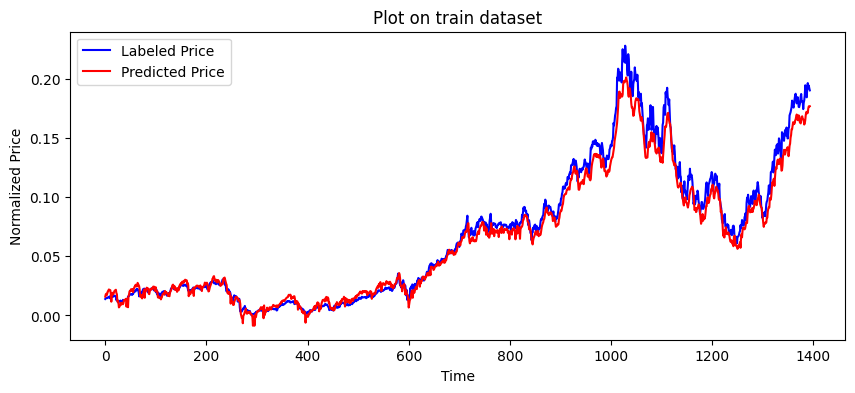

In [86]:
# Demo on test set
y_pred = model.predict(X_train)
plt.figure(figsize=(10,4))
plt.plot(y_train, color = 'blue', label = 'Labeled Price')
plt.plot(y_pred, color = 'red', label = 'Predicted Price')
# label x tick with datetime
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.title('Plot on train dataset')
plt.legend()
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


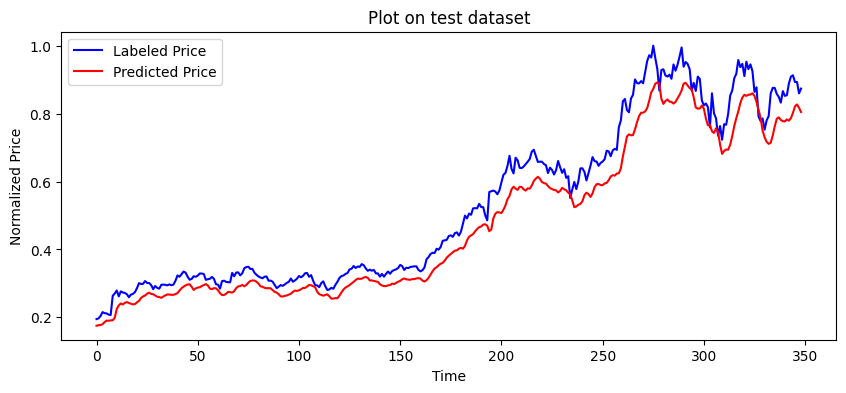

In [87]:
y_pred = model.predict(X_test)
plt.figure(figsize=(10,4))
plt.plot(y_test, color = 'blue', label = 'Labeled Price')
plt.plot(y_pred, color = 'red', label = 'Predicted Price')
# label x tick with datetime
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.title('Plot on test dataset')
plt.legend()
plt.show()

## Conclusion

The results from training a stock prediction model with and without sentiment data highlight the significant impact that sentiment analysis has on model performance.

### Without Sentiment Data:
- **Training MSE:** 0.000627
- **Training R-squared:** 0.815
- **Test MSE:** 0.00829
- **Test R-squared:** 0.858

The model without sentiment data shows a good fit with an **R-squared of 0.815** on the training set, indicating the model explains 81.5% of the variance in the training data. However, the test performance drops slightly with an **R-squared of 0.858**, reflecting a moderate ability to generalize to unseen data.

### With Sentiment Data:
- **Training MSE:** 0.000084
- **Training R-squared:** 0.975
- **Test MSE:** 0.00401
- **Test R-squared:** 0.931

Incorporating sentiment data into the model significantly improves both the training and test performance. The **training R-squared increases to 97.5%**, and more importantly, the **test R-squared jumps to 93.1%**, indicating the model can explain 93.1% of the variance in the test data. The **Test MSE** also decreases, reflecting a lower prediction error.

### Summary:
The inclusion of sentiment data enhances the model's predictive power and generalizability. The test results show a clear improvement in performance with sentiment data, emphasizing the value of sentiment analysis in stock prediction models. Thus, utilizing sentiment data from news sources provides a substantial boost to the accuracy and effectiveness of stock market predictions.
